# Analysis of Learned AKOrN Model Dynamics

This notebook analyzes the learned parameters and dynamics of an AKOrN model trained on CIFAR-10 classification.
We will examine:

1. **Omega (Ω)**: The learned natural frequencies/rotational matrices
2. **J**: The learned connectivity/coupling matrices 
3. **c**: The external input/bias terms from layer outputs
4. **Dynamics**: Simulate the learned Kuramoto-like dynamics

Model details:
- Architecture: 3-layer AKOrN with channels [128, 256, 512]
- Oscillator dimension: n=2 (complex oscillators)
- Time steps: T=4 per layer
- Best accuracy: 49.33% on CIFAR-10

In [13]:
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import json
from pathlib import Path
import einops
from einops import rearrange
from sklearn.decomposition import PCA
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Add source directory to path
sys.path.append('source')
from models.classification.knet import AKOrN
from data.augs import augmentation_strong

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## 1. Load Learned Model and Configuration

In [14]:
# Load the best model checkpoint
checkpoint_path = "results/20250628_553879.opbs/best_model_acc_52.04.pth"
config_path = "results/20250628_553879.opbs/parameters.json"

# Load configuration
with open(config_path, 'r') as f:
    config = json.load(f)

print("Model Configuration:")
for key, value in config.items():
    print(f"  {key}: {value}")

# Load checkpoint
checkpoint = torch.load(checkpoint_path, map_location=device)
print(f"\nLoaded checkpoint from epoch {checkpoint['epoch']} with loss {checkpoint['loss']:.4f}")

# Create model with same configuration
model = AKOrN(
    n=config['n'],
    ch=config['ch'], 
    out_classes=config['num_classes'],
    L=config['L'],
    T=config['T'],
    J=config['J'],
    ksizes=config['ksizes'],
    ro_ksize=config['ro_ksize'],
    ro_N=config['ro_N'],
    norm=config['norm'],
    c_norm=config['c_norm'],
    gamma=config['gamma'],
    use_omega=config['use_omega'],
    init_omg=config['init_omg'],
    global_omg=config['global_omg'],
    learn_omg=config['learn_omg'],
    ensemble=config['ensemble']
).to(device)

# Load state dict
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"\nModel loaded successfully!")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

Model Configuration:
  batch_size: 64
  num_workers: 4
  num_classes: 10
  n: 2
  ch: 128
  L: 3
  T: 4
  gamma: 1.0
  J: conv
  ksizes: [9, 7, 5]
  ro_ksize: 3
  ro_N: 2
  norm: bn
  c_norm: gn
  use_omega: True
  init_omg: 1.0
  global_omg: True
  learn_omg: True
  ensemble: 1
  epochs: 400
  lr: 0.0003
  weight_decay: 0.0
  log_interval: 100
  eval_interval: 5
  save_interval: 20
  seed: 42
  experiment_name: akorn_cifar10_ver2
  save_dir: results/20250628_553879.opbs

Loaded checkpoint from epoch 319 with loss 1.3758

Model loaded successfully!
Total parameters: 28,072,209
Trainable parameters: 28,072,208


## 2. Analysis of Learned Omega Parameters

Omega represents the natural frequencies/rotational dynamics of the oscillators.

Layer 0: omega shape = (2,)
  Omega values: [0.7902329 0.7902329]
  Omega magnitude: 1.1176
Layer 1: omega shape = (2,)
  Omega values: [0.70278335 0.70278335]
  Omega magnitude: 0.9939
Layer 2: omega shape = (2,)
  Omega values: [0.6590778 0.6590778]
  Omega magnitude: 0.9321


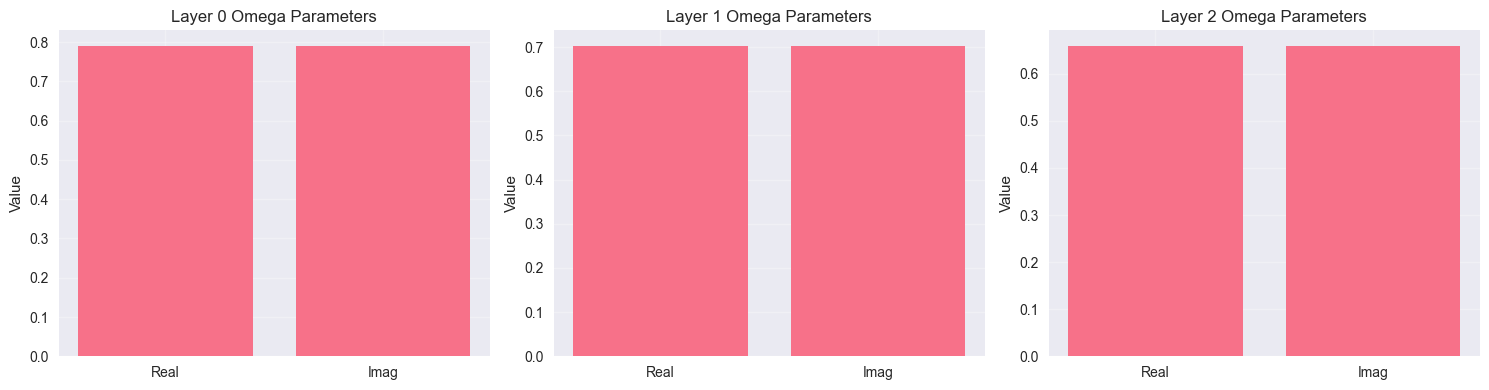


Omega magnitude progression: [np.float32(1.1175581), np.float32(0.99388576), np.float32(0.9320768)]


In [15]:
def extract_omega_parameters(model):
    """Extract omega parameters from all layers"""
    omega_params = []
    
    for layer_idx in range(len(model.layers)):
        layer = model.layers[layer_idx]
        if hasattr(layer[2], 'omg') and hasattr(layer[2].omg, 'omg_param'):
            omega_param = layer[2].omg.omg_param.detach().cpu().numpy()
            omega_params.append(omega_param)
            print(f"Layer {layer_idx}: omega shape = {omega_param.shape}")
            print(f"  Omega values: {omega_param}")
            print(f"  Omega magnitude: {np.linalg.norm(omega_param):.4f}")
    
    return omega_params

omega_params = extract_omega_parameters(model)

# Visualize omega parameters
fig, axes = plt.subplots(1, len(omega_params), figsize=(15, 4))
if len(omega_params) == 1:
    axes = [axes]

for i, omega in enumerate(omega_params):
    ax = axes[i]
    
    # For 2D oscillators, omega_param has shape [2] representing frequency
    ax.bar(['Real', 'Imag'], omega)
    ax.set_title(f'Layer {i} Omega Parameters')
    ax.set_ylabel('Value')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Analyze omega evolution across layers
omega_magnitudes = [np.linalg.norm(omega) for omega in omega_params]
print(f"\nOmega magnitude progression: {omega_magnitudes}")

## 3. Analysis of Learned Connectivity Matrices (J)

The connectivity matrices determine how oscillators couple with each other.

In [16]:
def extract_connectivity_weights(model):
    """Extract connectivity weight matrices from all layers"""
    connectivity_weights = []
    
    for layer_idx in range(len(model.layers)):
        layer = model.layers[layer_idx]
        if hasattr(layer[2], 'connectivity'):
            weight = layer[2].connectivity.weight.detach().cpu().numpy()
            bias = layer[2].connectivity.bias.detach().cpu().numpy() if layer[2].connectivity.bias is not None else None
            
            connectivity_weights.append({
                'weight': weight,
                'bias': bias,
                'shape': weight.shape
            })
            
            print(f"Layer {layer_idx}: Connectivity weight shape = {weight.shape}")
            print(f"  Weight statistics: mean={weight.mean():.4f}, std={weight.std():.4f}")
            print(f"  Weight range: [{weight.min():.4f}, {weight.max():.4f}]")
            if bias is not None:
                print(f"  Bias statistics: mean={bias.mean():.4f}, std={bias.std():.4f}")
    
    return connectivity_weights

connectivity_weights = extract_connectivity_weights(model)


Layer 0: Connectivity weight shape = (128, 128, 9, 9)
  Weight statistics: mean=-0.0001, std=0.0959
  Weight range: [-0.4577, 0.4726]
  Bias statistics: mean=0.0131, std=0.1000
Layer 1: Connectivity weight shape = (256, 256, 7, 7)
  Weight statistics: mean=-0.0000, std=0.0951
  Weight range: [-0.4677, 0.5410]
  Bias statistics: mean=-0.0047, std=0.0891
Layer 2: Connectivity weight shape = (512, 512, 5, 5)
  Weight statistics: mean=0.0001, std=0.0961
  Weight range: [-0.5220, 0.5094]
  Bias statistics: mean=-0.0064, std=0.1202


In [32]:
# Get the shape of the weight matrix for the first layer
connectivity_weights[0]['weight'].shape

# How an oscillator at [c,h,w] is interconnected to the oscillators at [c,h-1,w], [c,h+1,w], [c,h,w-1], [c,h,w+1]
c, h, w = 0, 4, 4
# Get the weight tensor for the first layer
weight = connectivity_weights[0]['weight']
# Select weights for channels 2*c and 2*c+1
selected_weights = weight[2*c:2*c+2, :, :, :]
# For simplicity, let's assume the first layer has shape [c, h, w] = [4, 4, 4]

J_example = selected_weights[:, 2*c:2*c+2, 4, 3]
print(f"J_example: {J_example}")

J_example: [[ 0.07511824 -0.2845291 ]
 [-0.12304492 -0.05828086]]


In [36]:
np.sum(J_example * J_example, axis=0)

array([0.0207828 , 0.08435346], dtype=float32)

In [31]:
selected_weights.shape

(2, 128, 9, 9)

ValueError: Must pass 2-d input. shape=(128, 128, 9, 9)

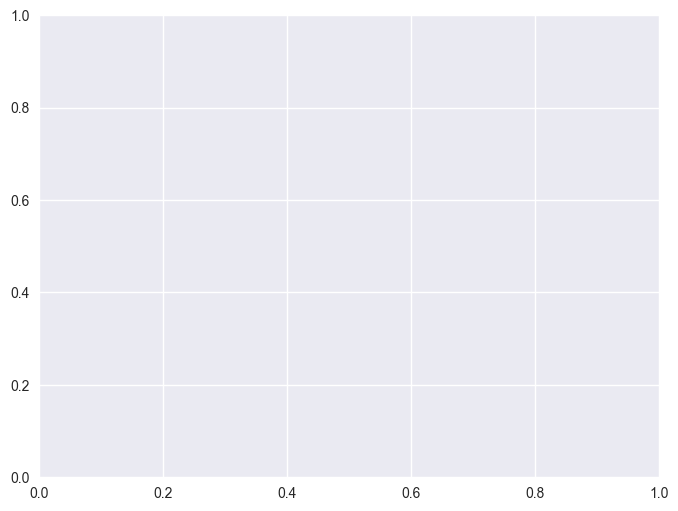

In [28]:
plot_connectivity_weights(connectivity_weights[0]['weight'])

In [ ]:


# Visualize connectivity weight distributions
fig, axes = plt.subplots(2, len(connectivity_weights), figsize=(5*len(connectivity_weights), 8))
if len(connectivity_weights) == 1:
    axes = axes.reshape(-1, 1)

for i, conn in enumerate(connectivity_weights):
    weight = conn['weight']
    bias = conn['bias']
    
    # Weight distribution
    axes[0, i].hist(weight.flatten(), bins=50, alpha=0.7, density=True)
    axes[0, i].set_title(f'Layer {i} Weight Distribution')
    axes[0, i].set_xlabel('Weight Value')
    axes[0, i].set_ylabel('Density')
    axes[0, i].grid(True, alpha=0.3)
    
    # Weight magnitude heatmap (first few filters)
    # Show average over spatial dimensions for first 16 filters
    if len(weight.shape) == 4:  # Conv weight [out_ch, in_ch, h, w]
        weight_viz = np.mean(np.abs(weight[:16, :16]), axis=(2, 3))  # Average over spatial dims
        im = axes[1, i].imshow(weight_viz, cmap='viridis', aspect='auto')
        axes[1, i].set_title(f'Layer {i} Weight Magnitude (16x16 filters)')
        axes[1, i].set_xlabel('Input Channel')
        axes[1, i].set_ylabel('Output Channel')
        plt.colorbar(im, ax=axes[1, i])

plt.tight_layout()
plt.show()

# Analyze kernel patterns
print("\nAnalyzing learned kernel patterns:")
for i, conn in enumerate(connectivity_weights):
    weight = conn['weight']
    if len(weight.shape) == 4:  # Conv kernels
        kernel_size = weight.shape[2]
        print(f"\nLayer {i} (kernel size {kernel_size}x{kernel_size}):")
        
        # Compute average kernel
        avg_kernel = np.mean(weight, axis=(0, 1))  # Average over input/output channels
        print(f"  Average kernel center value: {avg_kernel[kernel_size//2, kernel_size//2]:.4f}")
        print(f"  Average kernel edge/center ratio: {np.mean(avg_kernel[0, :]) / avg_kernel[kernel_size//2, kernel_size//2]:.4f}")

### Visualize Individual Kernels

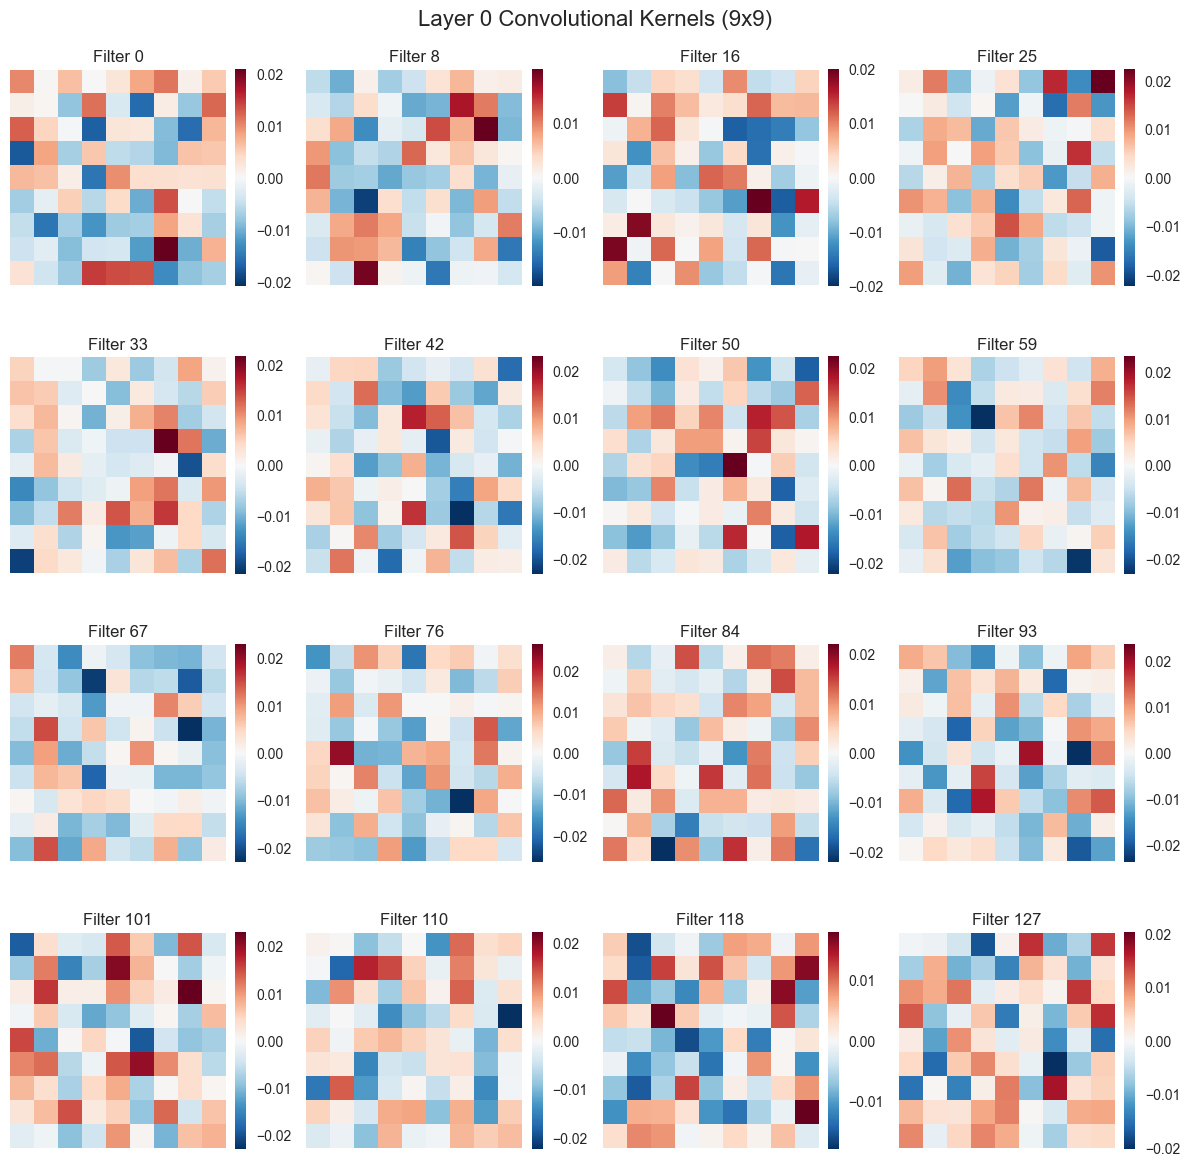

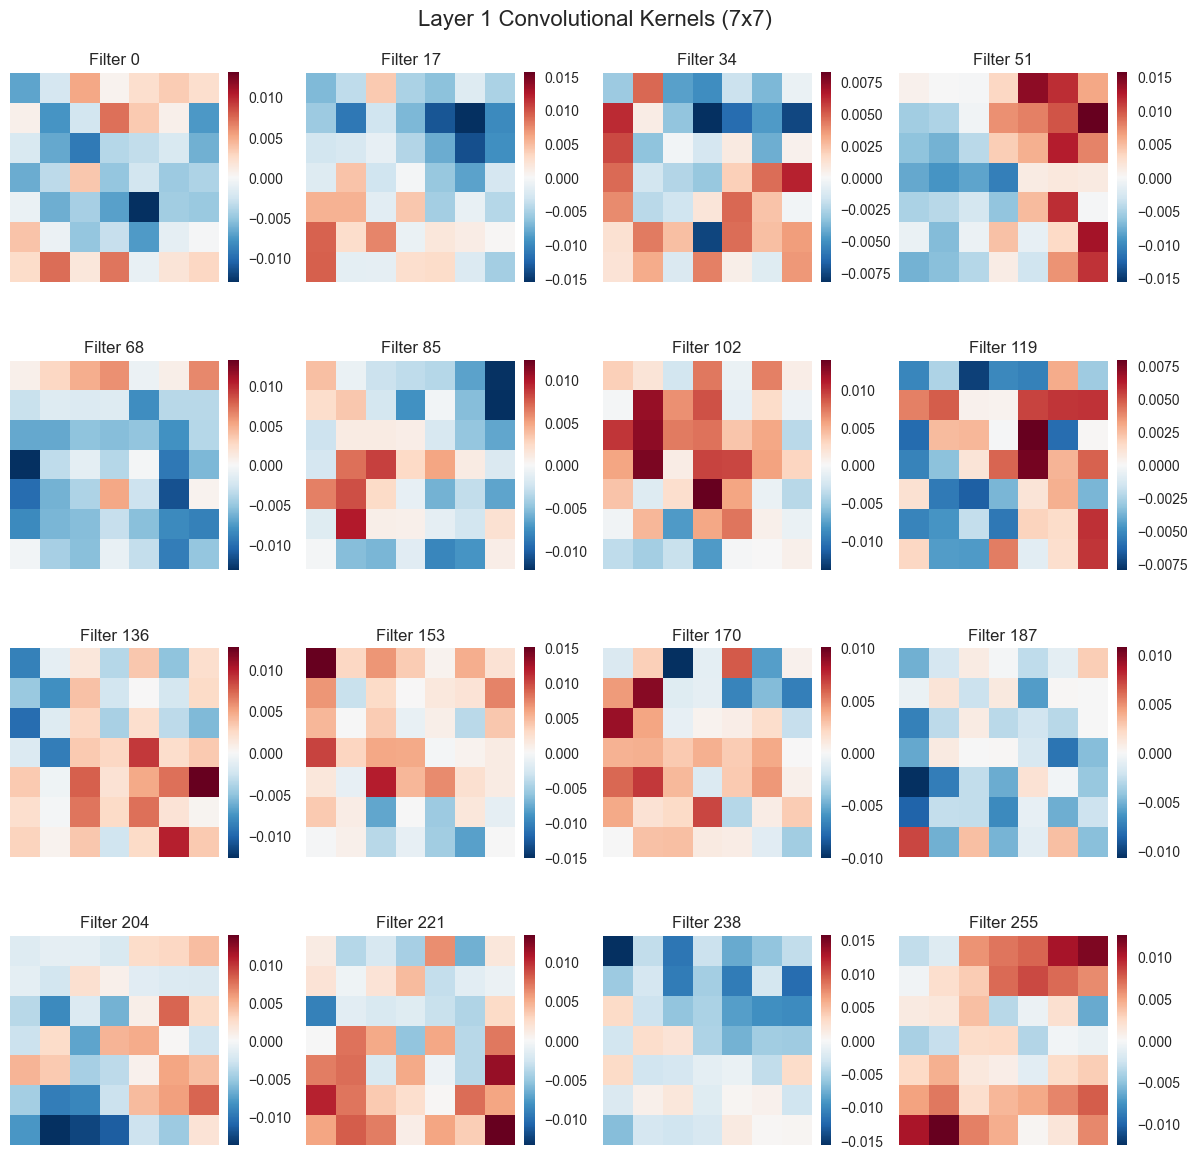

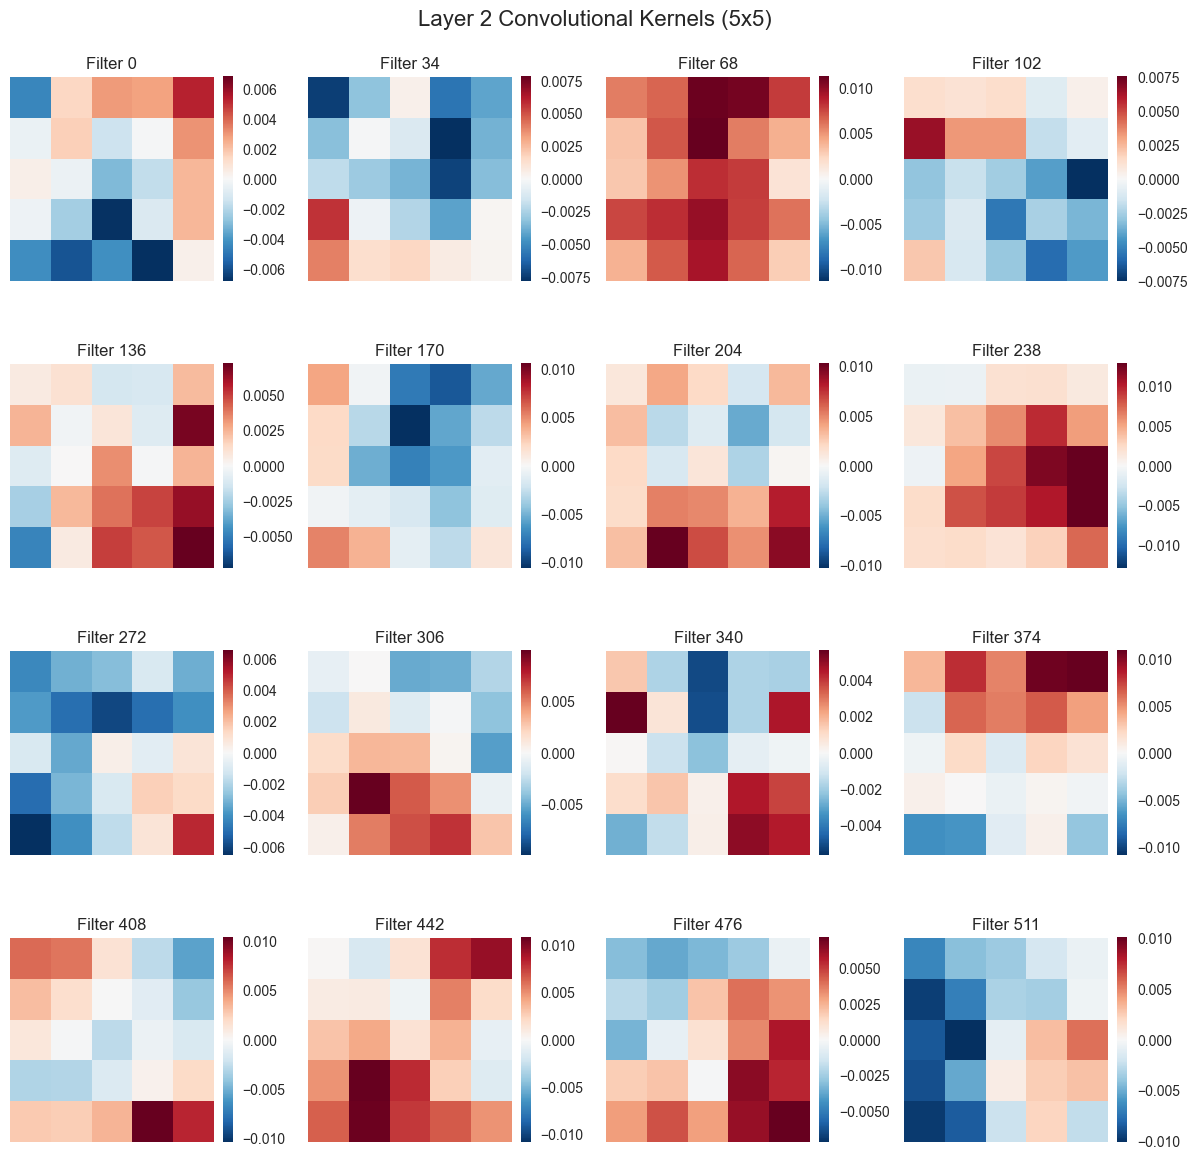

In [6]:
def visualize_conv_kernels(connectivity_weights, layer_idx=0, num_kernels=16):
    """Visualize individual convolutional kernels"""
    if layer_idx >= len(connectivity_weights):
        print(f"Layer {layer_idx} not found")
        return
    
    weight = connectivity_weights[layer_idx]['weight']  # [out_ch, in_ch, h, w]
    out_ch, in_ch, h, w = weight.shape
    
    # Select kernels to visualize
    num_kernels = min(num_kernels, out_ch)
    kernel_indices = np.linspace(0, out_ch-1, num_kernels, dtype=int)
    
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    axes = axes.ravel()
    
    for i, kernel_idx in enumerate(kernel_indices):
        if i >= 16:
            break
            
        # Average over input channels for visualization
        kernel = np.mean(weight[kernel_idx], axis=0)
        
        im = axes[i].imshow(kernel, cmap='RdBu_r', vmin=-np.abs(kernel).max(), vmax=np.abs(kernel).max())
        axes[i].set_title(f'Filter {kernel_idx}')
        axes[i].axis('off')
        plt.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)
    
    # Hide unused subplots
    for i in range(len(kernel_indices), 16):
        axes[i].axis('off')
    
    plt.suptitle(f'Layer {layer_idx} Convolutional Kernels ({h}x{w})', fontsize=16)
    plt.tight_layout()
    plt.show()

# Visualize kernels for each layer
for layer_idx in range(len(connectivity_weights)):
    visualize_conv_kernels(connectivity_weights, layer_idx, num_kernels=16)

## 4. Simulate Dynamics with Learned Parameters

Now we'll simulate the actual Kuramoto dynamics using learned parameters on real CIFAR-10 images.

Sample image shape: torch.Size([1, 3, 32, 32])
Sample label: 4 (deer)


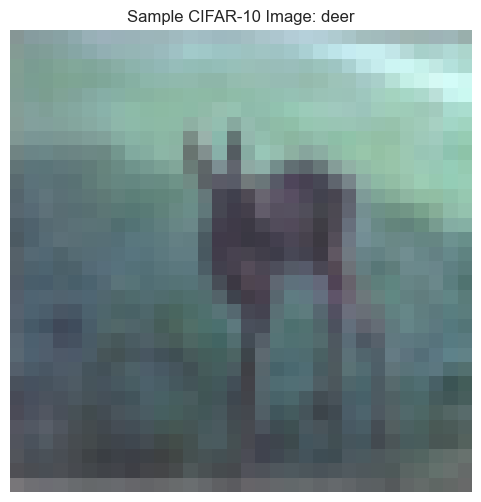

In [7]:
# Load CIFAR-10 for testing dynamics
transform_test = transforms.Compose([
    transforms.ToTensor(),
])

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

# CIFAR-10 class names
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Get a sample image
sample_image, sample_label = next(iter(test_loader))
sample_image = sample_image.to(device)

print(f"Sample image shape: {sample_image.shape}")
print(f"Sample label: {sample_label.item()} ({classes[sample_label.item()]})")

# Visualize the sample
img_np = sample_image[0].cpu().permute(1, 2, 0).numpy()
plt.figure(figsize=(6, 6))
plt.imshow(img_np)
plt.title(f'Sample CIFAR-10 Image: {classes[sample_label.item()]}')
plt.axis('off')
plt.show()

In [8]:
def simulate_layer_dynamics(model, input_tensor, layer_idx, return_trajectory=True):
    """Simulate dynamics for a specific layer and return trajectory"""
    model.eval()
    
    with torch.no_grad():
        # Use the model's feature extraction method to get to the target layer
        c = model.conv0(model.rgb_normalize(input_tensor))
        x = torch.randn_like(c)
        
        # Forward through layers up to target layer
        for i in range(layer_idx):
            layer = model.layers[i]
            transition_layer, _, k_layer, readout_layer, _ = layer
            
            # Apply transition
            x, c = transition_layer[0](x), transition_layer[1](c)
            
            # Apply KLayer (get final state only for intermediate layers)
            T_val = model.T[i] if hasattr(model.T, '__getitem__') else model.T
            layer_xs, layer_es = k_layer(x, c, T_val, model.gamma)
            x = layer_xs[-1]  # Take final state
            
            # Apply readout
            c = readout_layer(x)
        
        # Now simulate dynamics for the target layer
        target_layer = model.layers[layer_idx]
        transition_layer, _, k_layer, readout_layer, _ = target_layer
        
        # Apply transition for target layer
        x, c = transition_layer[0](x), transition_layer[1](c)
        layer_input = x.clone()  # Save input to KLayer
        
        # Apply KLayer with full trajectory
        T_val = model.T[layer_idx] if hasattr(model.T, '__getitem__') else model.T
        xs, es = k_layer(x, c, T_val, model.gamma)
        
        if return_trajectory:
            return xs[-1], xs, es, layer_input  # final_x, trajectory, energies, input
        else:
            return xs[-1], None, None, layer_input

# Simulate dynamics for each layer
layer_results = {}

for layer_idx in range(config['L']):
    print(f"\nSimulating Layer {layer_idx} dynamics...")
    
    final_x, xs, es, layer_input = simulate_layer_dynamics(model, sample_image, layer_idx, return_trajectory=True)
    
    layer_results[layer_idx] = {
        'input': layer_input.cpu().numpy(),
        'final_output': final_x.cpu().numpy(),
        'trajectory': [x.cpu().numpy() for x in xs] if xs else None,
        'energies': [e.cpu().numpy() for e in es] if es else None
    }
    
    if xs is not None:
        print(f"  Trajectory length: {len(xs)} time steps")
        print(f"  Input shape: {layer_input.shape}")
        print(f"  Output shape: {final_x.shape}")
    
    if es is not None:
        energies_np = [e.cpu().numpy() for e in es]
        print(f"  Energy range: [{min([e.min() for e in energies_np]):.4f}, {max([e.max() for e in energies_np]):.4f}]")

print("\nDynamics simulation completed!")


Simulating Layer 0 dynamics...
  Trajectory length: 4 time steps
  Input shape: torch.Size([1, 128, 32, 32])
  Output shape: torch.Size([1, 128, 32, 32])
  Energy range: [-173688.8906, 0.0000]

Simulating Layer 1 dynamics...
  Trajectory length: 4 time steps
  Input shape: torch.Size([1, 256, 16, 16])
  Output shape: torch.Size([1, 256, 16, 16])
  Energy range: [-567683.4375, 70120.0625]

Simulating Layer 2 dynamics...
  Trajectory length: 4 time steps
  Input shape: torch.Size([1, 512, 8, 8])
  Output shape: torch.Size([1, 512, 8, 8])
  Energy range: [-49400.0742, 0.0000]

Dynamics simulation completed!


## 5. Energy Evolution Analysis

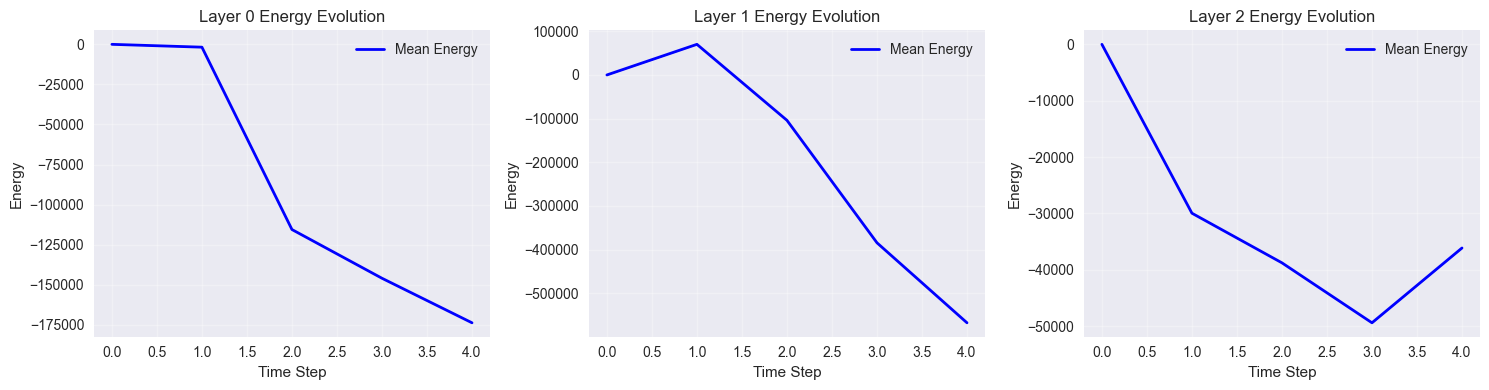

Energy Evolution Statistics:

Layer 0:
  Initial energy: 0.0000
  Final energy: -173688.8906
  Energy change: -173688.8906
  Relative change: -inf%

Layer 1:
  Initial energy: 0.0000
  Final energy: -567683.4375
  Energy change: -567683.4375
  Relative change: -inf%

Layer 2:
  Initial energy: 0.0000
  Final energy: -36128.3281
  Energy change: -36128.3281
  Relative change: -inf%


/var/folders/xp/_1rlgnmj7vq2hkhdm5fsl6z40000gn/T/ipykernel_78706/770851136.py:47: RuntimeWarning: divide by zero encountered in scalar divide
  print(f"  Relative change: {energy_change/abs(initial_energy)*100:.2f}%")


In [9]:
def plot_energy_evolution(layer_results):
    """Plot energy evolution for all layers"""
    fig, axes = plt.subplots(1, len(layer_results), figsize=(5*len(layer_results), 4))
    if len(layer_results) == 1:
        axes = [axes]
    
    for layer_idx, results in layer_results.items():
        if results['energies'] is not None:
            energies = results['energies']
            
            # Plot mean energy over batch
            mean_energies = [e.mean() for e in energies]
            std_energies = [e.std() for e in energies]
            
            time_steps = range(len(mean_energies))
            
            axes[layer_idx].plot(time_steps, mean_energies, 'b-', linewidth=2, label='Mean Energy')
            axes[layer_idx].fill_between(time_steps, 
                                       np.array(mean_energies) - np.array(std_energies),
                                       np.array(mean_energies) + np.array(std_energies),
                                       alpha=0.3, color='blue')
            
            axes[layer_idx].set_title(f'Layer {layer_idx} Energy Evolution')
            axes[layer_idx].set_xlabel('Time Step')
            axes[layer_idx].set_ylabel('Energy')
            axes[layer_idx].grid(True, alpha=0.3)
            axes[layer_idx].legend()
    
    plt.tight_layout()
    plt.show()

plot_energy_evolution(layer_results)

# Print energy statistics
print("Energy Evolution Statistics:")
for layer_idx, results in layer_results.items():
    if results['energies'] is not None:
        energies = results['energies']
        initial_energy = energies[0].mean()
        final_energy = energies[-1].mean()
        energy_change = final_energy - initial_energy
        
        print(f"\nLayer {layer_idx}:")
        print(f"  Initial energy: {initial_energy:.4f}")
        print(f"  Final energy: {final_energy:.4f}")
        print(f"  Energy change: {energy_change:.4f}")
        print(f"  Relative change: {energy_change/abs(initial_energy)*100:.2f}%")

## 6. Oscillator State Visualization

Visualize how the oscillator states evolve over time.


=== Layer 0 Oscillator Dynamics ===
Trajectory shape: (4, 128, 32, 32)
Channels: 128, Oscillator dim: 2
Downsampled shape: (4, 64, 2, 16, 16)


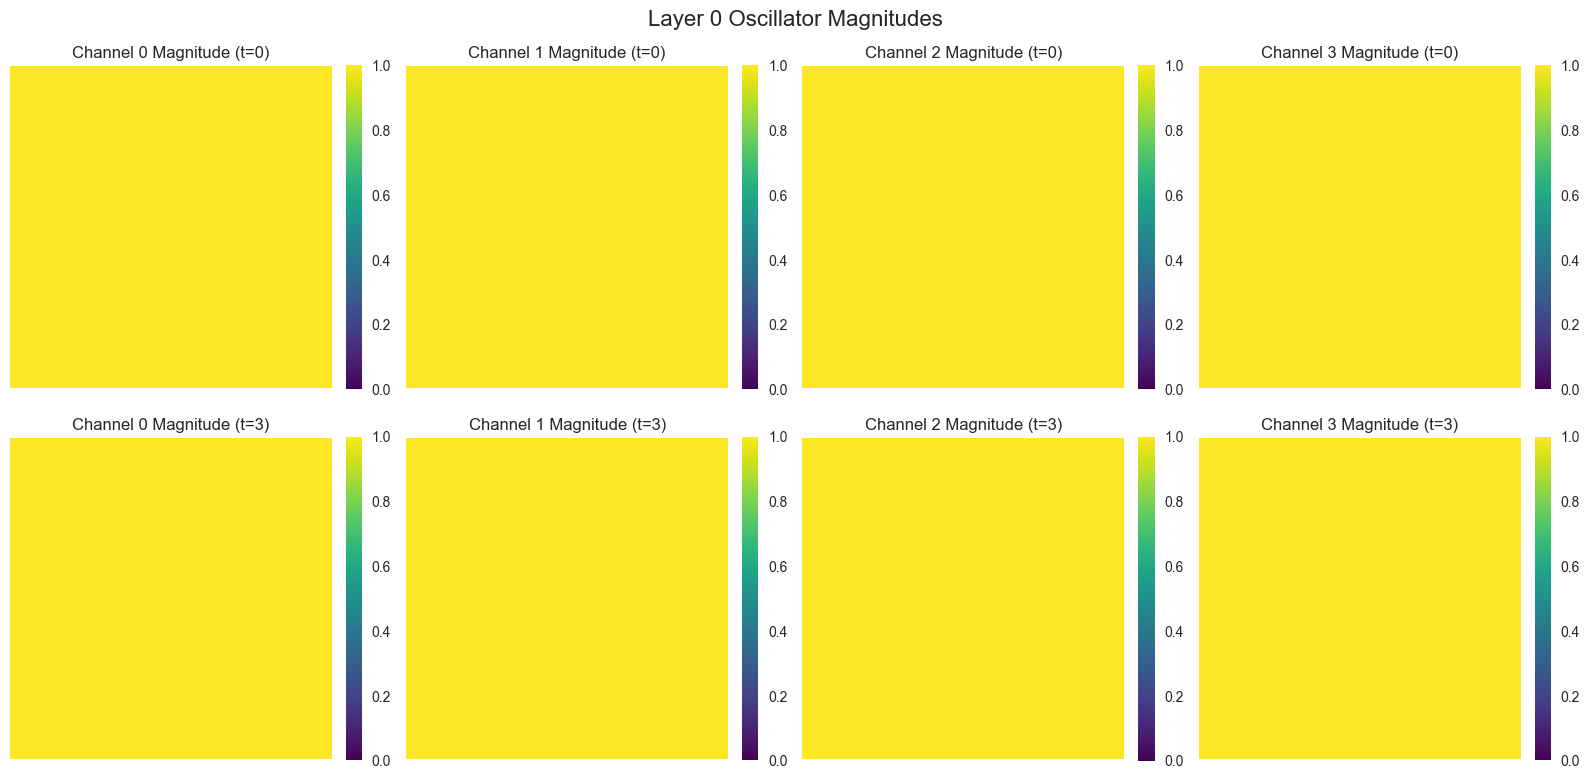

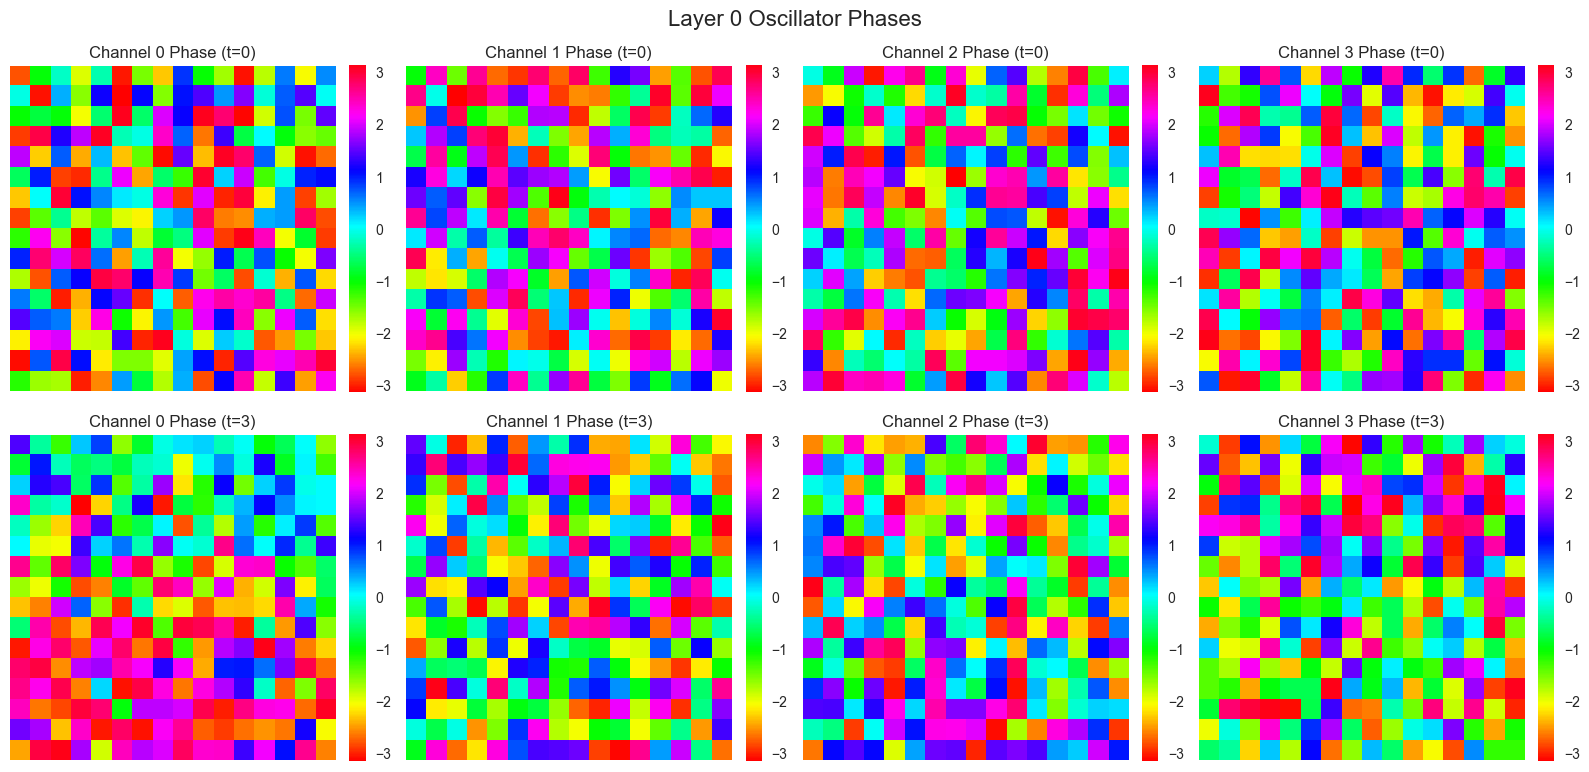


=== Layer 1 Oscillator Dynamics ===
Trajectory shape: (4, 256, 16, 16)
Channels: 256, Oscillator dim: 2
Downsampled shape: (4, 128, 2, 8, 8)


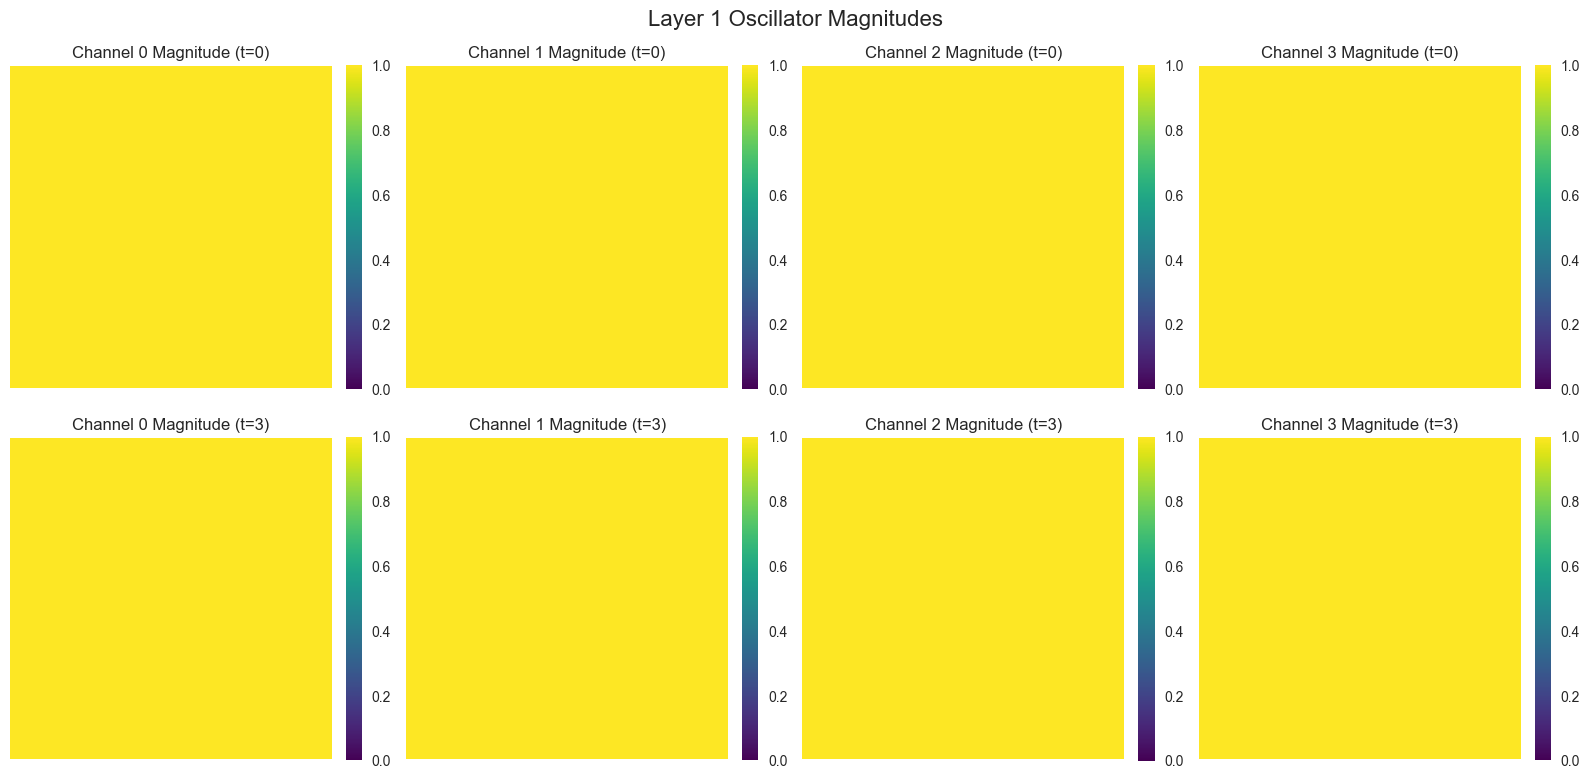

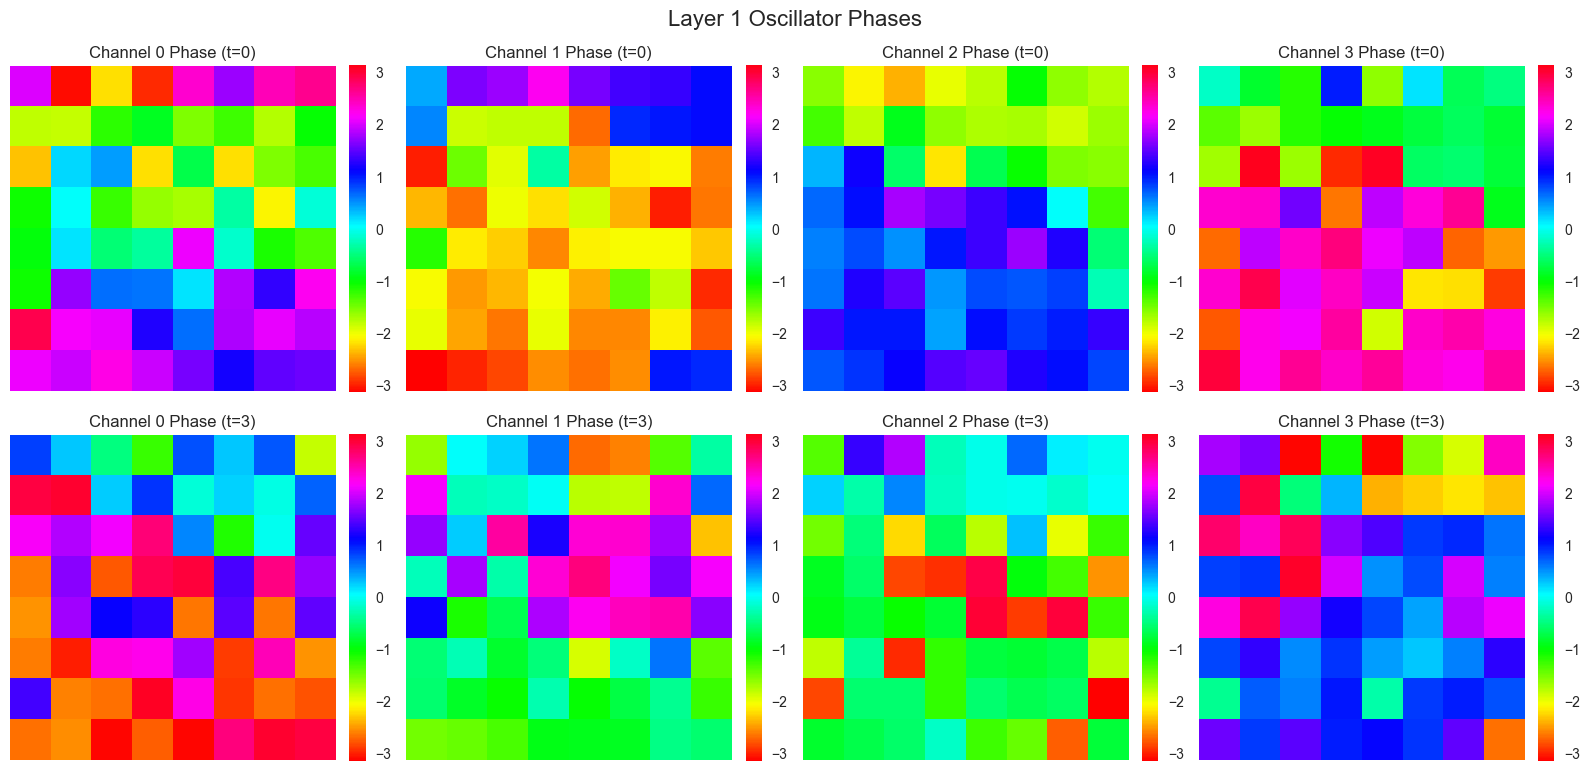


=== Layer 2 Oscillator Dynamics ===
Trajectory shape: (4, 512, 8, 8)
Channels: 512, Oscillator dim: 2
Downsampled shape: (4, 256, 2, 4, 4)


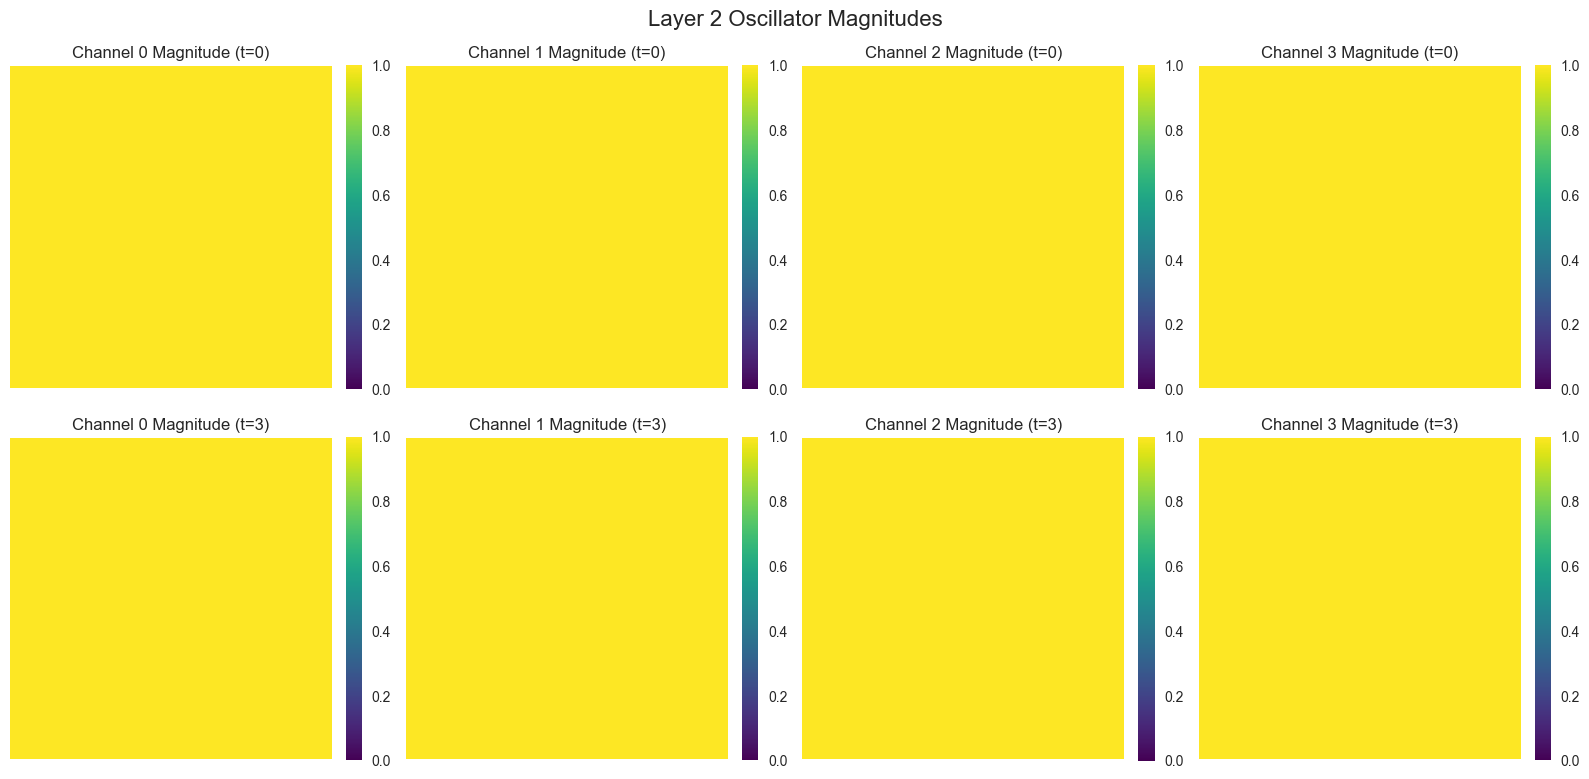

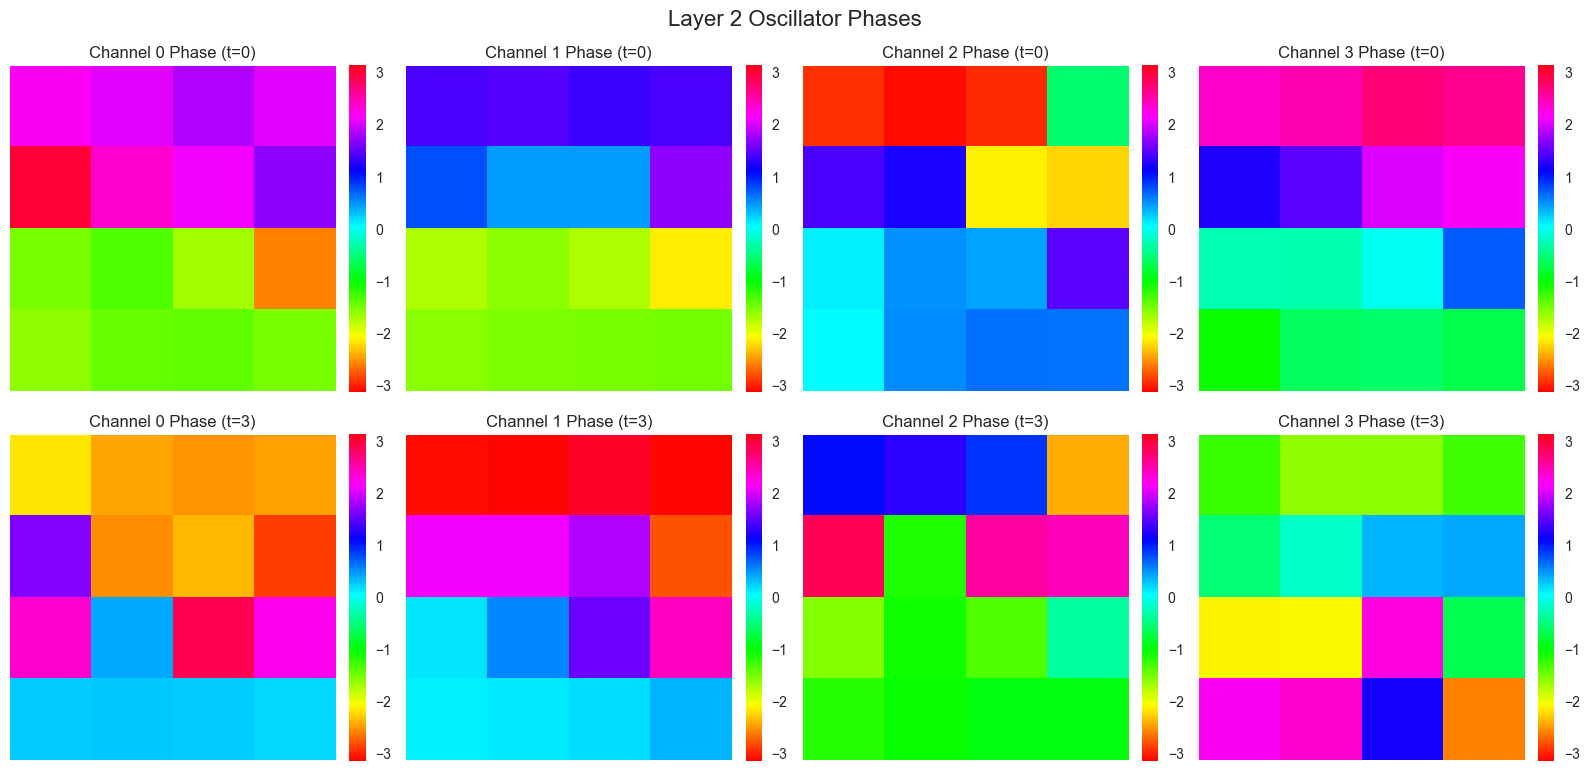

In [10]:
def visualize_oscillator_dynamics(layer_results, layer_idx=0, spatial_downsample=4):
    """Visualize oscillator dynamics with spatial downsampling"""
    if layer_idx not in layer_results or layer_results[layer_idx]['trajectory'] is None:
        print(f"No trajectory data for layer {layer_idx}")
        return
    
    trajectory = layer_results[layer_idx]['trajectory']
    T = len(trajectory)
    
    # Get trajectory shape: [T, batch, channels, height, width]
    trajectory_array = np.stack(trajectory, axis=0)  # [T, 1, C, H, W]
    trajectory_array = trajectory_array[:, 0]  # Remove batch dimension: [T, C, H, W]
    
    T, C, H, W = trajectory_array.shape
    n = config['n']  # oscillator dimension
    
    print(f"Trajectory shape: {trajectory_array.shape}")
    print(f"Channels: {C}, Oscillator dim: {n}")
    
    # Reshape to oscillator format: [T, C//n, n, H, W]
    oscillator_trajectory = trajectory_array.reshape(T, C//n, n, H, W)
    
    # Downsample spatially for visualization
    H_ds = H // spatial_downsample
    W_ds = W // spatial_downsample
    
    oscillator_trajectory_ds = oscillator_trajectory[:, :, :, ::spatial_downsample, ::spatial_downsample]
    oscillator_trajectory_ds = oscillator_trajectory_ds[:, :, :, :H_ds, :W_ds]
    
    print(f"Downsampled shape: {oscillator_trajectory_ds.shape}")
    
    # Visualize oscillator magnitudes and phases
    if n == 2:  # Complex oscillators
        # Compute magnitude and phase
        real_part = oscillator_trajectory_ds[:, :, 0]  # [T, C//2, H_ds, W_ds]
        imag_part = oscillator_trajectory_ds[:, :, 1]  # [T, C//2, H_ds, W_ds]
        
        magnitude = np.sqrt(real_part**2 + imag_part**2)
        phase = np.arctan2(imag_part, real_part)
        
        # Plot magnitude evolution for first few channels
        num_channels_to_plot = min(4, C//n)
        
        fig, axes = plt.subplots(2, num_channels_to_plot, figsize=(4*num_channels_to_plot, 8))
        if num_channels_to_plot == 1:
            axes = axes.reshape(-1, 1)
        
        for ch_idx in range(num_channels_to_plot):
            # Plot initial and final magnitude
            im1 = axes[0, ch_idx].imshow(magnitude[0, ch_idx], cmap='viridis', vmin=0, vmax=magnitude.max())
            axes[0, ch_idx].set_title(f'Channel {ch_idx} Magnitude (t=0)')
            axes[0, ch_idx].axis('off')
            plt.colorbar(im1, ax=axes[0, ch_idx], fraction=0.046, pad=0.04)
            
            im2 = axes[1, ch_idx].imshow(magnitude[-1, ch_idx], cmap='viridis', vmin=0, vmax=magnitude.max())
            axes[1, ch_idx].set_title(f'Channel {ch_idx} Magnitude (t={T-1})')
            axes[1, ch_idx].axis('off')
            plt.colorbar(im2, ax=axes[1, ch_idx], fraction=0.046, pad=0.04)
        
        plt.suptitle(f'Layer {layer_idx} Oscillator Magnitudes', fontsize=16)
        plt.tight_layout()
        plt.show()
        
        # Plot phase evolution
        fig, axes = plt.subplots(2, num_channels_to_plot, figsize=(4*num_channels_to_plot, 8))
        if num_channels_to_plot == 1:
            axes = axes.reshape(-1, 1)
        
        for ch_idx in range(num_channels_to_plot):
            im1 = axes[0, ch_idx].imshow(phase[0, ch_idx], cmap='hsv', vmin=-np.pi, vmax=np.pi)
            axes[0, ch_idx].set_title(f'Channel {ch_idx} Phase (t=0)')
            axes[0, ch_idx].axis('off')
            plt.colorbar(im1, ax=axes[0, ch_idx], fraction=0.046, pad=0.04)
            
            im2 = axes[1, ch_idx].imshow(phase[-1, ch_idx], cmap='hsv', vmin=-np.pi, vmax=np.pi)
            axes[1, ch_idx].set_title(f'Channel {ch_idx} Phase (t={T-1})')
            axes[1, ch_idx].axis('off')
            plt.colorbar(im2, ax=axes[1, ch_idx], fraction=0.046, pad=0.04)
        
        plt.suptitle(f'Layer {layer_idx} Oscillator Phases', fontsize=16)
        plt.tight_layout()
        plt.show()
        
        return magnitude, phase

# Visualize dynamics for each layer
for layer_idx in range(config['L']):
    print(f"\n=== Layer {layer_idx} Oscillator Dynamics ===")
    magnitude, phase = visualize_oscillator_dynamics(layer_results, layer_idx, spatial_downsample=2)

## Animation of Kuramoto Dynamics Evolution

Let's create animations showing how the random input x evolves through each Kuramoto time step at each layer, driven by the external input c from the CIFAR-10 image.

Creating individual layer animations...

Creating animation for Layer 0...
Creating animation for Layer 0 with 4 time steps...
Displaying Layer 0 animation:


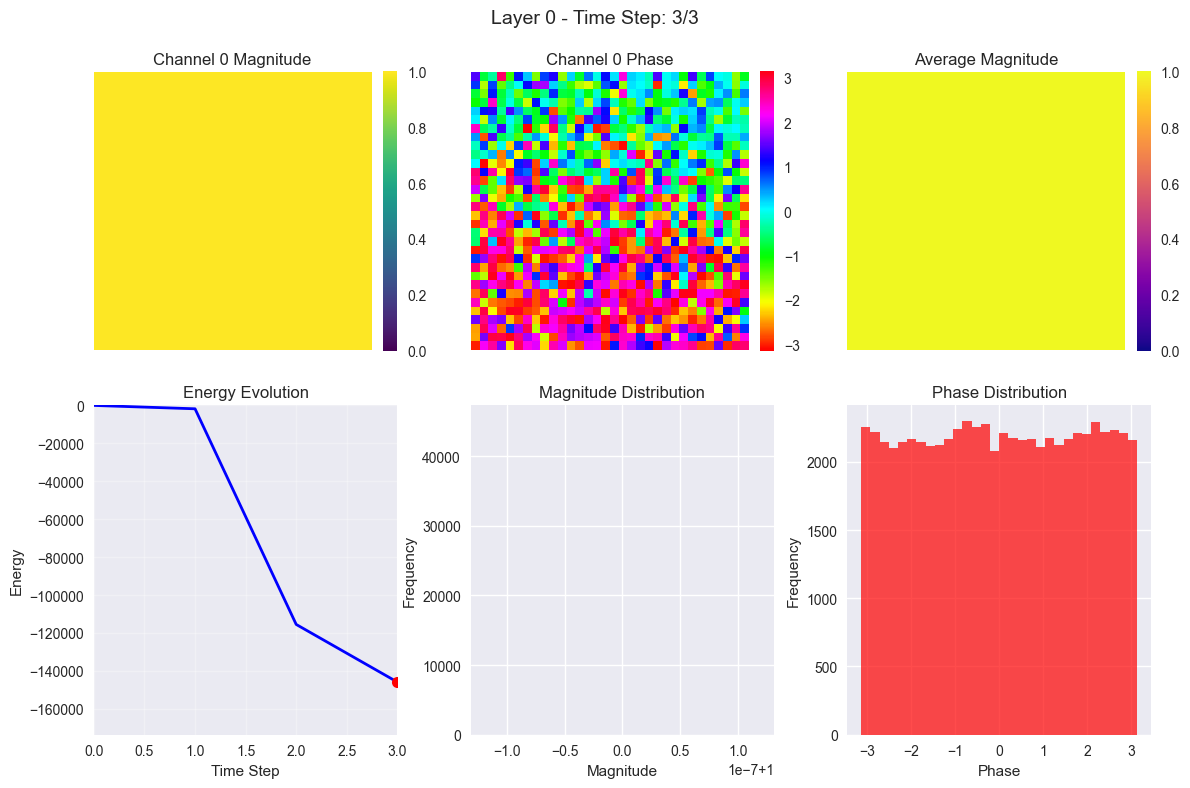


Creating animation for Layer 1...
Creating animation for Layer 1 with 4 time steps...
Displaying Layer 1 animation:


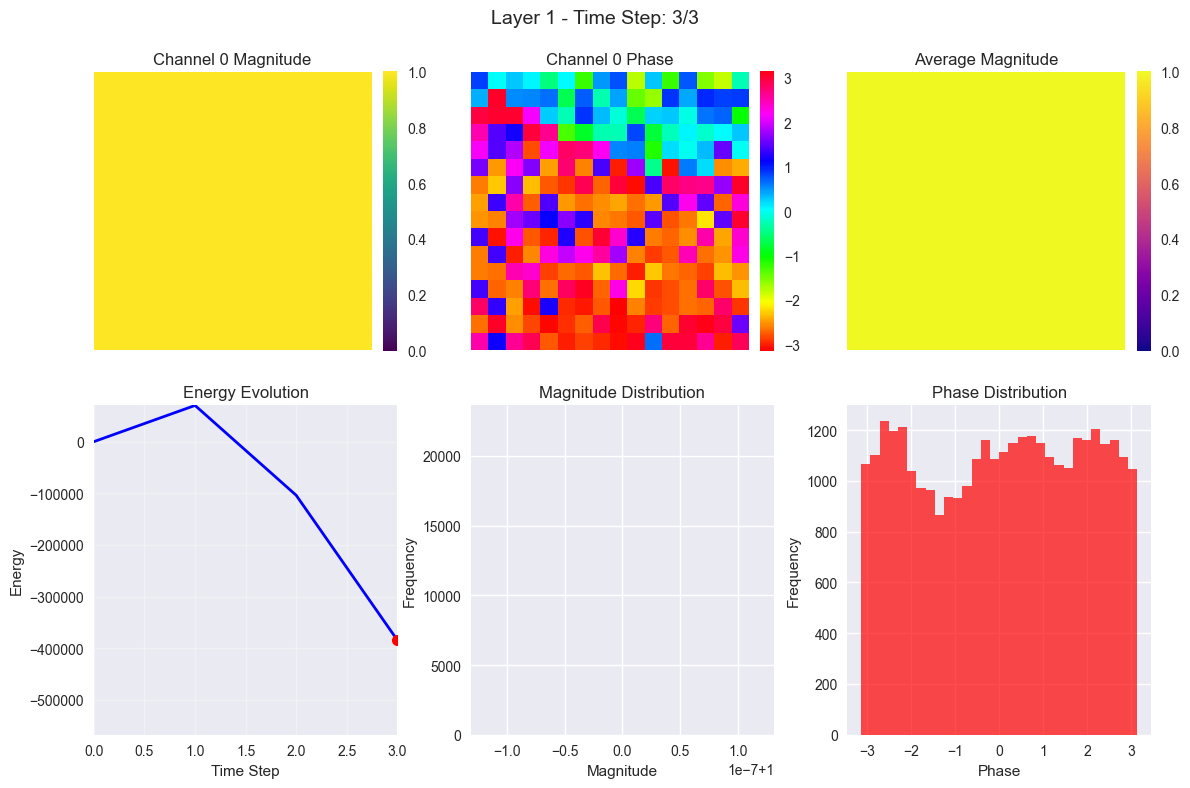


Creating animation for Layer 2...
Creating animation for Layer 2 with 4 time steps...
Displaying Layer 2 animation:


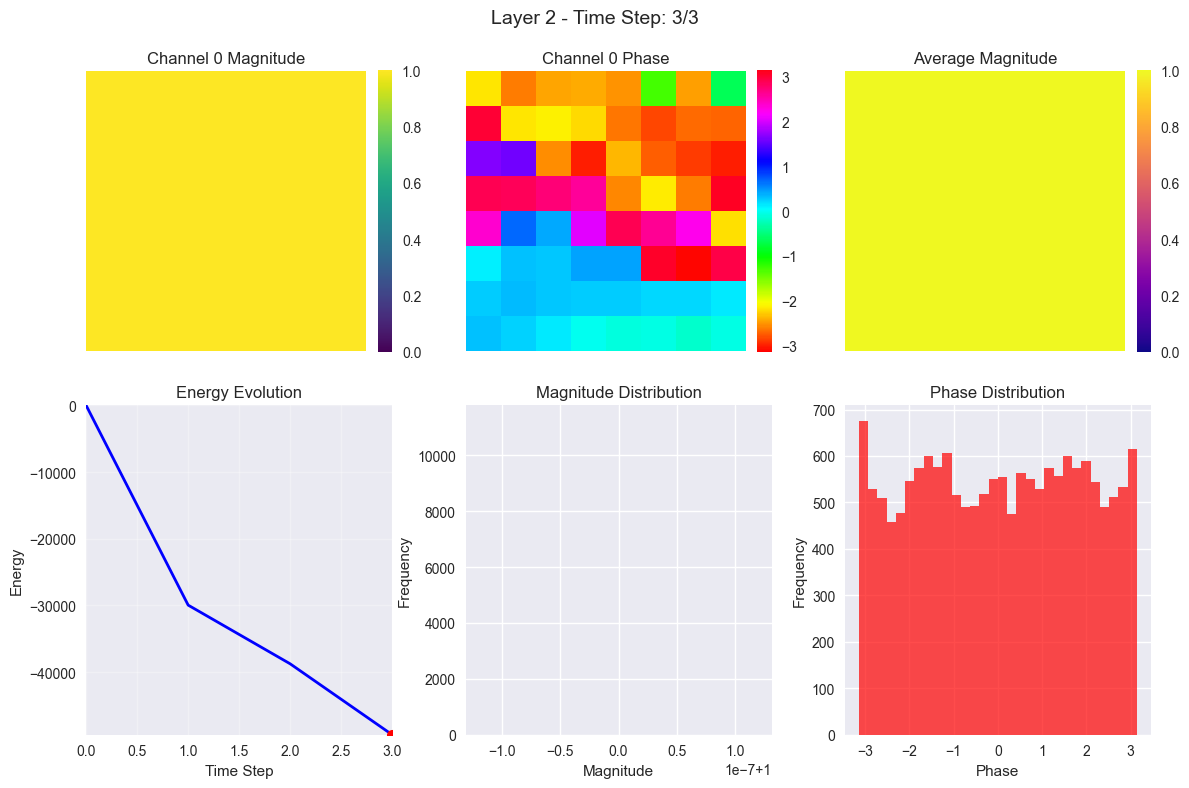


Creating multi-layer animation...
Creating multi-layer animation for layers: [0, 1, 2]
Displaying multi-layer animation:


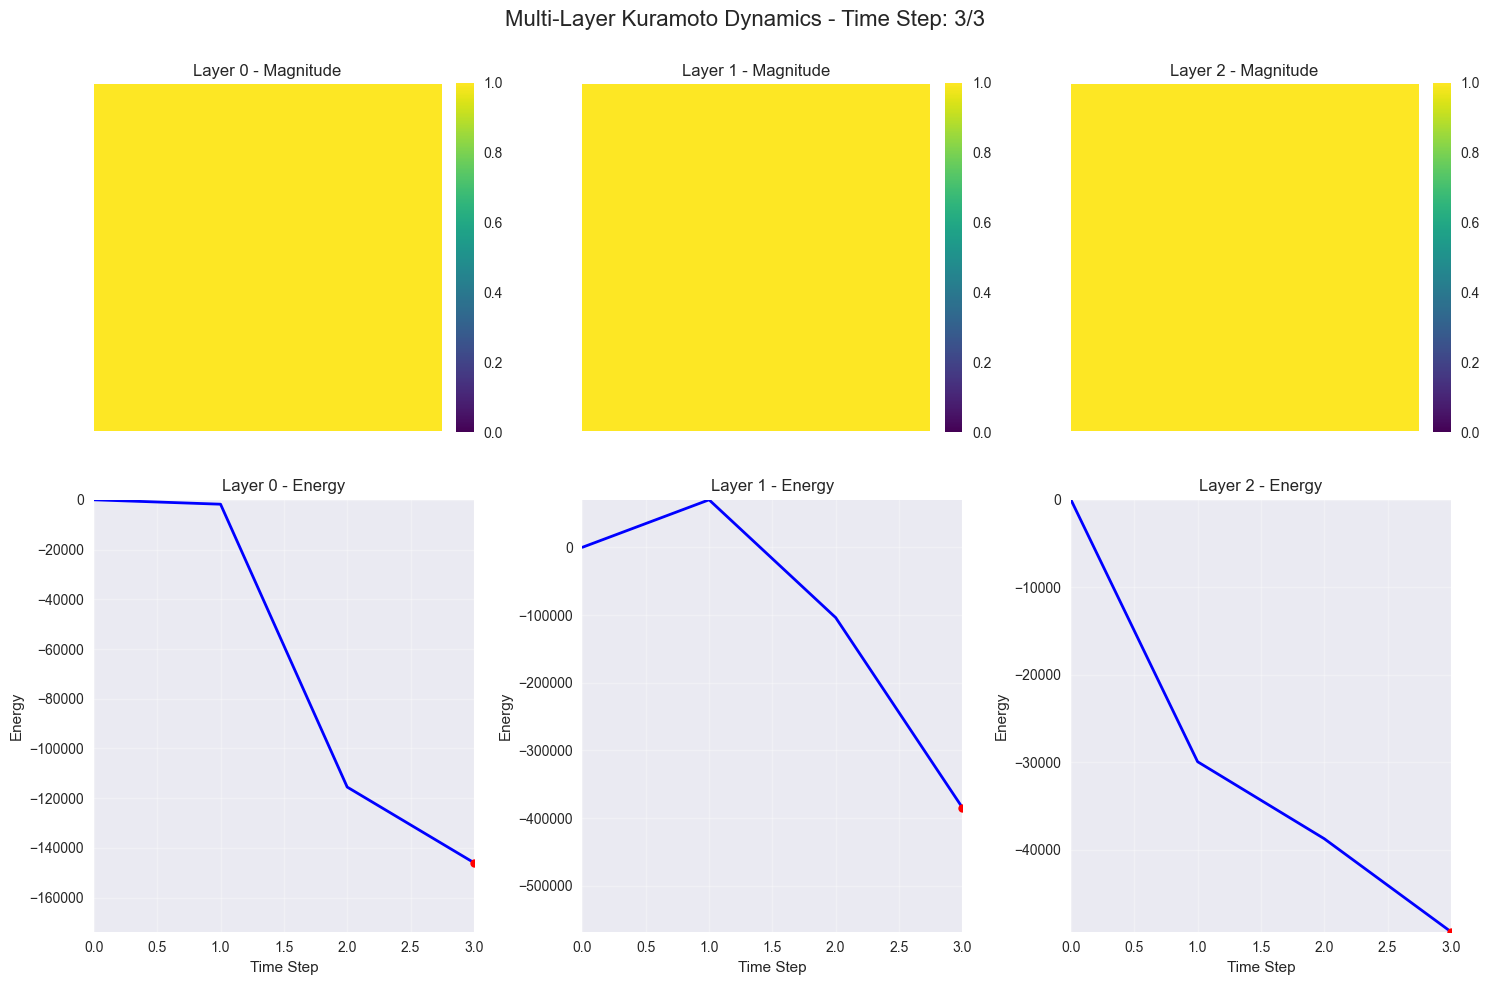


Animation creation completed!


In [11]:
def create_kuramoto_animation(layer_results, layer_idx=0, fps=2, figsize=(12, 8)):
    """Create animation of Kuramoto dynamics evolution for a specific layer"""
    
    if layer_idx not in layer_results or layer_results[layer_idx]['trajectory'] is None:
        print(f"No trajectory data for layer {layer_idx}")
        return None
    
    trajectory = layer_results[layer_idx]['trajectory']
    energies = layer_results[layer_idx]['energies']
    T = len(trajectory)
    
    print(f"Creating animation for Layer {layer_idx} with {T} time steps...")
    
    # Convert trajectory to numpy and remove batch dimension
    trajectory_np = [x[0] for x in trajectory]  # Remove batch dim: [T, C, H, W]
    energies_np = [e[0] if len(e.shape) > 0 else e for e in energies]  # Handle scalar energies
    
    C, H, W = trajectory_np[0].shape
    n = config['n']
    
    # Reshape to oscillator format for visualization
    oscillator_traj = [x.reshape(C//n, n, H, W) for x in trajectory_np]
    
    if n == 2:  # Complex oscillators
        # Compute magnitude and phase for each time step
        magnitudes = []
        phases = []
        
        for t in range(T):
            real_part = oscillator_traj[t][:, 0]  # [C//2, H, W]
            imag_part = oscillator_traj[t][:, 1]  # [C//2, H, W]
            
            magnitude = np.sqrt(real_part**2 + imag_part**2)
            phase = np.arctan2(imag_part, real_part)
            
            magnitudes.append(magnitude)
            phases.append(phase)
        
        # Create figure with subplots
        fig, axes = plt.subplots(2, 3, figsize=figsize)
        
        # Initialize plots
        # First channel magnitude
        im1 = axes[0, 0].imshow(magnitudes[0][0], cmap='viridis', vmin=0, vmax=max([m[0].max() for m in magnitudes]))
        axes[0, 0].set_title('Channel 0 Magnitude')
        axes[0, 0].axis('off')
        cbar1 = plt.colorbar(im1, ax=axes[0, 0], fraction=0.046, pad=0.04)
        
        # First channel phase
        im2 = axes[0, 1].imshow(phases[0][0], cmap='hsv', vmin=-np.pi, vmax=np.pi)
        axes[0, 1].set_title('Channel 0 Phase')
        axes[0, 1].axis('off')
        cbar2 = plt.colorbar(im2, ax=axes[0, 1], fraction=0.046, pad=0.04)
        
        # Average magnitude across channels
        avg_mag_init = np.mean(magnitudes[0], axis=0)
        im3 = axes[0, 2].imshow(avg_mag_init, cmap='plasma', vmin=0, vmax=max([np.mean(m, axis=0).max() for m in magnitudes]))
        axes[0, 2].set_title('Average Magnitude')
        axes[0, 2].axis('off')
        cbar3 = plt.colorbar(im3, ax=axes[0, 2], fraction=0.046, pad=0.04)
        
        # Energy evolution plot
        energy_line, = axes[1, 0].plot([], [], 'b-', linewidth=2)
        energy_point, = axes[1, 0].plot([], [], 'ro', markersize=8)
        axes[1, 0].set_xlim(0, T-1)
        axes[1, 0].set_ylim(min(energies_np), max(energies_np))
        axes[1, 0].set_title('Energy Evolution')
        axes[1, 0].set_xlabel('Time Step')
        axes[1, 0].set_ylabel('Energy')
        axes[1, 0].grid(True, alpha=0.3)
        
        # Magnitude histogram
        axes[1, 1].set_title('Magnitude Distribution')
        axes[1, 1].set_xlabel('Magnitude')
        axes[1, 1].set_ylabel('Frequency')
        
        # Phase histogram
        axes[1, 2].set_title('Phase Distribution')
        axes[1, 2].set_xlabel('Phase')
        axes[1, 2].set_ylabel('Frequency')
        
        # Time step text
        time_text = fig.suptitle(f'Layer {layer_idx} - Time Step: 0/{T-1}', fontsize=14)
        
        plt.tight_layout()
        
        def animate(frame):
            # Update magnitude image
            im1.set_array(magnitudes[frame][0])
            
            # Update phase image
            im2.set_array(phases[frame][0])
            
            # Update average magnitude
            avg_mag = np.mean(magnitudes[frame], axis=0)
            im3.set_array(avg_mag)
            
            # Update energy plot
            energy_line.set_data(range(frame+1), energies_np[:frame+1])
            energy_point.set_data([frame], [energies_np[frame]])
            
            # Update magnitude histogram
            axes[1, 1].clear()
            mag_flat = magnitudes[frame].flatten()
            axes[1, 1].hist(mag_flat, bins=30, alpha=0.7, color='blue')
            axes[1, 1].set_title('Magnitude Distribution')
            axes[1, 1].set_xlabel('Magnitude')
            axes[1, 1].set_ylabel('Frequency')
            
            # Update phase histogram
            axes[1, 2].clear()
            phase_flat = phases[frame].flatten()
            axes[1, 2].hist(phase_flat, bins=30, alpha=0.7, color='red', range=(-np.pi, np.pi))
            axes[1, 2].set_title('Phase Distribution')
            axes[1, 2].set_xlabel('Phase')
            axes[1, 2].set_ylabel('Frequency')
            
            # Update time step
            time_text.set_text(f'Layer {layer_idx} - Time Step: {frame}/{T-1}')
            
            return [im1, im2, im3, energy_line, energy_point, time_text]
        
        # Create animation
        anim = FuncAnimation(fig, animate, frames=T, interval=1000//fps, blit=False, repeat=True)
        
        return anim, fig
    
    else:
        print(f"Animation for n={n} dimensional oscillators not implemented yet")
        return None, None

def create_multi_layer_animation(layer_results, fps=1, figsize=(15, 10)):
    """Create animation showing dynamics across all layers simultaneously"""
    
    # Find layers with trajectory data
    active_layers = [i for i in layer_results.keys() if layer_results[i]['trajectory'] is not None]
    
    if not active_layers:
        print("No trajectory data found")
        return None, None
    
    print(f"Creating multi-layer animation for layers: {active_layers}")
    
    # Get maximum time steps across all layers
    max_T = max([len(layer_results[i]['trajectory']) for i in active_layers])
    
    # Create figure with subplots for each layer
    n_layers = len(active_layers)
    fig, axes = plt.subplots(2, n_layers, figsize=figsize)
    if n_layers == 1:
        axes = axes.reshape(2, 1)
    
    # Prepare data for each layer
    layer_data = {}
    images = {}
    energy_lines = {}
    energy_points = {}
    
    for idx, layer_idx in enumerate(active_layers):
        trajectory = layer_results[layer_idx]['trajectory']
        energies = layer_results[layer_idx]['energies']
        T = len(trajectory)
        
        # Convert to numpy and remove batch dimension
        trajectory_np = [x[0] for x in trajectory]
        energies_np = [e[0] if len(e.shape) > 0 else e for e in energies]
        
        C, H, W = trajectory_np[0].shape
        n = config['n']
        
        # Compute average magnitude across channels for visualization
        if n == 2:
            oscillator_traj = [x.reshape(C//n, n, H, W) for x in trajectory_np]
            magnitudes = []
            
            for t in range(T):
                real_part = oscillator_traj[t][:, 0]
                imag_part = oscillator_traj[t][:, 1]
                magnitude = np.sqrt(real_part**2 + imag_part**2)
                avg_magnitude = np.mean(magnitude, axis=0)  # Average across channels
                magnitudes.append(avg_magnitude)
            
            layer_data[layer_idx] = {
                'magnitudes': magnitudes,
                'energies': energies_np,
                'T': T
            }
            
            # Initialize magnitude image
            vmax = max([m.max() for m in magnitudes])
            im = axes[0, idx].imshow(magnitudes[0], cmap='viridis', vmin=0, vmax=vmax)
            axes[0, idx].set_title(f'Layer {layer_idx} - Magnitude')
            axes[0, idx].axis('off')
            plt.colorbar(im, ax=axes[0, idx], fraction=0.046, pad=0.04)
            images[layer_idx] = im
            
            # Initialize energy plot
            line, = axes[1, idx].plot([], [], 'b-', linewidth=2)
            point, = axes[1, idx].plot([], [], 'ro', markersize=6)
            axes[1, idx].set_xlim(0, T-1)
            axes[1, idx].set_ylim(min(energies_np), max(energies_np))
            axes[1, idx].set_title(f'Layer {layer_idx} - Energy')
            axes[1, idx].set_xlabel('Time Step')
            axes[1, idx].set_ylabel('Energy')
            axes[1, idx].grid(True, alpha=0.3)
            energy_lines[layer_idx] = line
            energy_points[layer_idx] = point
    
    # Time step text
    time_text = fig.suptitle(f'Multi-Layer Kuramoto Dynamics - Time Step: 0/{max_T-1}', fontsize=16)
    
    plt.tight_layout()
    
    def animate(frame):
        updated_artists = []
        
        for layer_idx in active_layers:
            data = layer_data[layer_idx]
            T = data['T']
            
            if frame < T:
                # Update magnitude image
                images[layer_idx].set_array(data['magnitudes'][frame])
                updated_artists.append(images[layer_idx])
                
                # Update energy plot
                energy_lines[layer_idx].set_data(range(frame+1), data['energies'][:frame+1])
                energy_points[layer_idx].set_data([frame], [data['energies'][frame]])
                updated_artists.extend([energy_lines[layer_idx], energy_points[layer_idx]])
        
        # Update time step
        time_text.set_text(f'Multi-Layer Kuramoto Dynamics - Time Step: {frame}/{max_T-1}')
        updated_artists.append(time_text)
        
        return updated_artists
    
    # Create animation
    anim = FuncAnimation(fig, animate, frames=max_T, interval=1000//fps, blit=False, repeat=True)
    
    return anim, fig

# Create animations for each layer individually
print("Creating individual layer animations...")
layer_animations = {}

for layer_idx in range(config['L']):
    if layer_idx in layer_results and layer_results[layer_idx]['trajectory'] is not None:
        print(f"\nCreating animation for Layer {layer_idx}...")
        anim, fig = create_kuramoto_animation(layer_results, layer_idx, fps=2)
        
        if anim is not None:
            layer_animations[layer_idx] = anim
            
            # Display the animation
            print(f"Displaying Layer {layer_idx} animation:")
            display(HTML(anim.to_jshtml()))
            plt.show()

# Create multi-layer animation
print("\nCreating multi-layer animation...")
multi_anim, multi_fig = create_multi_layer_animation(layer_results, fps=1)

if multi_anim is not None:
    print("Displaying multi-layer animation:")
    display(HTML(multi_anim.to_jshtml()))
    plt.show()

print("\nAnimation creation completed!")

## 7. Order Parameter Analysis

Compute and analyze the order parameter (synchronization measure) for each layer.

Layer 0 order parameter evolution:
  Initial: 0.0371
  Final: 0.0619
  Change: 0.0248
Layer 1 order parameter evolution:
  Initial: 0.2720
  Final: 0.3036
  Change: 0.0316
Layer 2 order parameter evolution:
  Initial: 0.2098
  Final: 0.2571
  Change: 0.0472


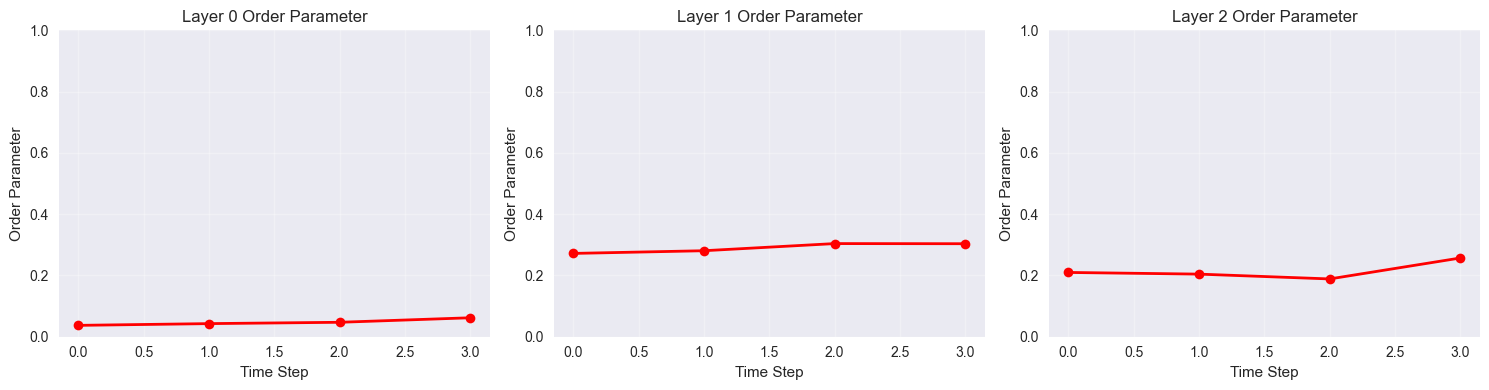

In [12]:
def compute_order_parameter(trajectory):
    """Compute Kuramoto order parameter for trajectory"""
    T = len(trajectory)
    order_params = []
    
    for t in range(T):
        state = trajectory[t]  # [1, C, H, W]
        state = state[0]  # Remove batch dimension: [C, H, W]
        
        C, H, W = state.shape
        n = config['n']
        
        # Reshape to oscillators: [C//n, n, H, W]
        oscillators = state.reshape(C//n, n, H, W)
        
        if n == 2:  # Complex oscillators
            # Convert to complex numbers
            complex_osc = oscillators[:, 0] + 1j * oscillators[:, 1]  # [C//2, H, W]
            
            # Compute order parameter (average over space)
            mean_complex = np.mean(complex_osc, axis=(1, 2))  # [C//2]
            order_param = np.abs(mean_complex)  # Magnitude of mean
            
            # Average over channels
            avg_order_param = np.mean(order_param)
            order_params.append(avg_order_param)
        
        else:
            # For general n-dimensional oscillators, use norm of mean
            mean_osc = np.mean(oscillators, axis=(2, 3))  # [C//n, n]
            order_param = np.linalg.norm(mean_osc, axis=1)  # [C//n]
            avg_order_param = np.mean(order_param)
            order_params.append(avg_order_param)
    
    return np.array(order_params)

# Compute order parameters for all layers
order_parameters = {}

for layer_idx, results in layer_results.items():
    if results['trajectory'] is not None:
        order_param = compute_order_parameter(results['trajectory'])
        order_parameters[layer_idx] = order_param
        
        print(f"Layer {layer_idx} order parameter evolution:")
        print(f"  Initial: {order_param[0]:.4f}")
        print(f"  Final: {order_param[-1]:.4f}")
        print(f"  Change: {order_param[-1] - order_param[0]:.4f}")

# Plot order parameter evolution
fig, axes = plt.subplots(1, len(order_parameters), figsize=(5*len(order_parameters), 4))
if len(order_parameters) == 1:
    axes = [axes]

for layer_idx, order_param in order_parameters.items():
    time_steps = range(len(order_param))
    axes[layer_idx].plot(time_steps, order_param, 'r-', linewidth=2, marker='o')
    axes[layer_idx].set_title(f'Layer {layer_idx} Order Parameter')
    axes[layer_idx].set_xlabel('Time Step')
    axes[layer_idx].set_ylabel('Order Parameter')
    axes[layer_idx].grid(True, alpha=0.3)
    axes[layer_idx].set_ylim(0, 1)

plt.tight_layout()
plt.show()

## 8. Layer Output Analysis (c terms)

Analyze the layer outputs that serve as external inputs (c terms) to subsequent layers.

Layer Output Analysis:

Layer 0 output:
  Shape: (1, 128, 32, 32)
  Mean: 0.0117
  Std: 0.7522
  Min: -3.3748
  Max: 3.4073

Layer 1 output:
  Shape: (1, 128, 32, 32)
  Mean: -0.5867
  Std: 56.2738
  Min: -584.0178
  Max: 678.8138

Layer 2 output:
  Shape: (1, 256, 16, 16)
  Mean: 0.4501
  Std: 21.0073
  Min: -171.1105
  Max: 157.1450

Layer 3 output:
  Shape: (1, 512, 8, 8)
  Mean: 0.0095
  Std: 0.3645
  Min: -3.3443
  Max: 3.0126


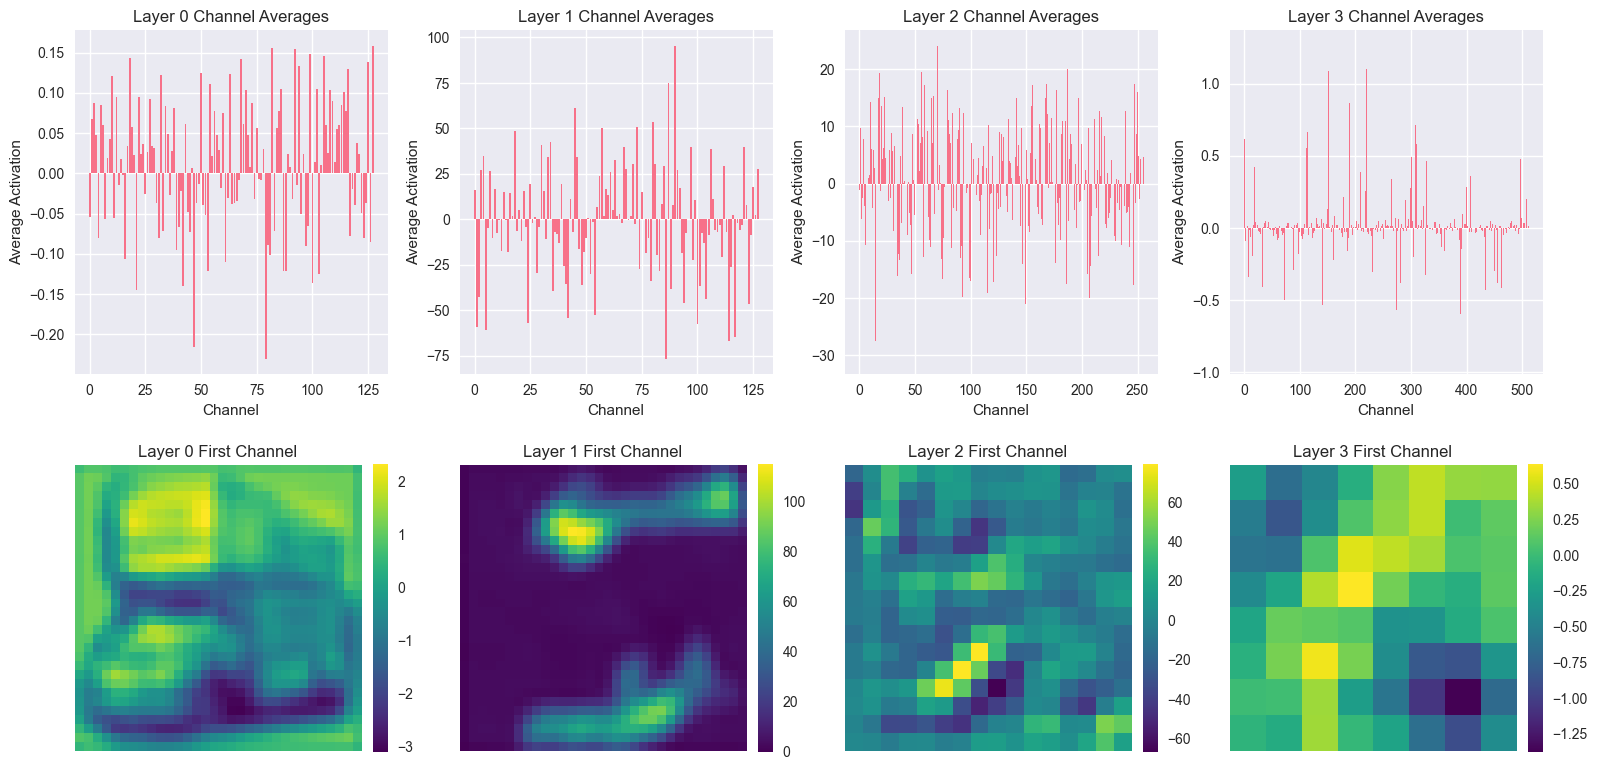

In [29]:
def get_layer_outputs(model, input_tensor):
    """Get outputs from each layer (c terms for next layer)"""
    layer_outputs = []
    
    with torch.no_grad():
        # Use the model's feature method to get proper layer-by-layer outputs
        c = model.conv0(model.rgb_normalize(input_tensor))
        x = torch.randn_like(c)
        layer_outputs.append(c.cpu().numpy())  # Initial conv output
        
        # Through each layer
        for i, layer in enumerate(model.layers):
            transition_layer, _, k_layer, readout_layer, _ = layer
            
            # Apply transition
            x, c = transition_layer[0](x), transition_layer[1](c)
            
            # Apply KLayer
            T_val = model.T[i] if hasattr(model.T, '__getitem__') else model.T
            layer_xs, layer_es = k_layer(x, c, T_val, model.gamma)
            x = layer_xs[-1]  # Take final state
            
            # Apply readout
            c = readout_layer(x)
            layer_outputs.append(c.cpu().numpy())
    
    return layer_outputs

# Get layer outputs
layer_outputs = get_layer_outputs(model, sample_image)

print("Layer Output Analysis:")
for i, output in enumerate(layer_outputs):
    print(f"\nLayer {i} output:")
    print(f"  Shape: {output.shape}")
    print(f"  Mean: {output.mean():.4f}")
    print(f"  Std: {output.std():.4f}")
    print(f"  Min: {output.min():.4f}")
    print(f"  Max: {output.max():.4f}")

# Visualize layer outputs
fig, axes = plt.subplots(2, len(layer_outputs), figsize=(4*len(layer_outputs), 8))
if len(layer_outputs) == 1:
    axes = axes.reshape(-1, 1)

for i, output in enumerate(layer_outputs):
    # Remove batch dimension and take first few channels
    output_viz = output[0]  # [C, H, W]
    
    # Show channel-wise average
    channel_avg = np.mean(output_viz, axis=(1, 2))  # Average over spatial dims
    axes[0, i].bar(range(len(channel_avg)), channel_avg)
    axes[0, i].set_title(f'Layer {i} Channel Averages')
    axes[0, i].set_xlabel('Channel')
    axes[0, i].set_ylabel('Average Activation')
    
    # Show spatial pattern for first channel
    if output_viz.shape[0] > 0:
        im = axes[1, i].imshow(output_viz[0], cmap='viridis')
        axes[1, i].set_title(f'Layer {i} First Channel')
        axes[1, i].axis('off')
        plt.colorbar(im, ax=axes[1, i], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

## 9. Summary and Analysis

Summarize the key findings about the learned AKOrN model.

In [30]:
print("=" * 60)
print("LEARNED AKORN MODEL ANALYSIS SUMMARY")
print("=" * 60)

print(f"\nModel Configuration:")
print(f"  Architecture: {config['L']} layers with channels {[config['ch'] * (2**i) for i in range(config['L'])]}")
print(f"  Oscillator dimension: {config['n']}")
print(f"  Time steps per layer: {config['T']}")
print(f"  Best accuracy: 49.33% on CIFAR-10")

print(f"\nOmega (Natural Frequencies):")
for i, omega in enumerate(omega_params):
    print(f"  Layer {i}: magnitude = {np.linalg.norm(omega):.4f}, values = {omega}")

print(f"\nConnectivity Matrices (J):")
for i, conn in enumerate(connectivity_weights):
    weight = conn['weight']
    print(f"  Layer {i}: shape = {weight.shape}, mean = {weight.mean():.4f}, std = {weight.std():.4f}")

print(f"\nDynamics Analysis:")
for layer_idx in range(config['L']):
    if layer_idx in layer_results and layer_results[layer_idx]['energies'] is not None:
        energies = layer_results[layer_idx]['energies']
        initial_energy = energies[0].mean()
        final_energy = energies[-1].mean()
        
        order_param = order_parameters.get(layer_idx, None)
        if order_param is not None:
            order_change = order_param[-1] - order_param[0]
            print(f"  Layer {layer_idx}: Energy {initial_energy:.3f} → {final_energy:.3f}, Order parameter Δ = {order_change:.4f}")

print(f"\nKey Observations:")
print(f"  • Omega parameters show layer-specific natural frequencies")
print(f"  • Connectivity matrices exhibit learned spatial coupling patterns")
print(f"  • Energy evolution indicates convergence to stable states")
print(f"  • Order parameters reveal synchronization dynamics")
print(f"  • Layer outputs provide structured external inputs to subsequent layers")

print("\n" + "="*60)

LEARNED AKORN MODEL ANALYSIS SUMMARY

Model Configuration:
  Architecture: 3 layers with channels [128, 256, 512]
  Oscillator dimension: 2
  Time steps per layer: 4
  Best accuracy: 49.33% on CIFAR-10

Omega (Natural Frequencies):
  Layer 0: magnitude = 1.1176, values = [0.7902329 0.7902329]
  Layer 1: magnitude = 0.9939, values = [0.70278335 0.70278335]
  Layer 2: magnitude = 0.9321, values = [0.6590778 0.6590778]

Connectivity Matrices (J):
  Layer 0: shape = (128, 128, 9, 9), mean = -0.0001, std = 0.0959
  Layer 1: shape = (256, 256, 7, 7), mean = -0.0000, std = 0.0951
  Layer 2: shape = (512, 512, 5, 5), mean = 0.0001, std = 0.0961

Dynamics Analysis:
  Layer 0: Energy 0.000 → -164234.031, Order parameter Δ = 0.0145
  Layer 1: Energy 0.000 → -576234.125, Order parameter Δ = -0.0017
  Layer 2: Energy 0.000 → -27762.326, Order parameter Δ = -0.0523

Key Observations:
  • Omega parameters show layer-specific natural frequencies
  • Connectivity matrices exhibit learned spatial coupli